In [2]:
import os
import numpy as np
import pandas as pd
from nilearn import masking, image
from scipy.stats import ttest_1samp, pearsonr,ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
sns.set_style('white')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


def p2sign(p):
    if  p<=0.001:
        sign='***'
    elif p<=0.01:
        sign='**'
    elif p<=0.05:
        sign='*'
    else:
        sign='n.s.'
    return sign


def bootstrap_indirect_effect(data, iv, m, dv, n_bootstraps=5000, ci=0.95):
    indirect_effects = []
    for _ in range(n_bootstraps):
        bootstrap_data = data.sample(frac=1, replace=True)

        path_a = smf.ols(f"{m} ~ {iv}", data=bootstrap_data).fit()
        path_b = smf.ols(f"{dv} ~ {m} + {iv}", data=bootstrap_data).fit()

        indirect_effect = path_a.params[1] * path_b.params[1]
        indirect_effects.append(indirect_effect)

    lower = np.percentile(indirect_effects, (1 - ci) / 2 * 100)
    upper = np.percentile(indirect_effects, (1 + ci) / 2 * 100)

    return lower, upper,indirect_effects

## Plot ROI mean effect

In [ ]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('game2_fmri>=0.5')
subjects = data['Participant_ID'].to_list()
# set camp
cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/hexagon_spct/Setall/6fold/{}/zmap/hexagon_zmap.nii.gz'
sub_cmap_paths = [cmap_template.format(sub_id) for sub_id in subjects]

# set roi
# roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/lHC_MNI152NL.nii.gz')
# roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/rHC_MNI152NL.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
#roi = image.load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/hexagon_spct/EC_thr3.1.nii.gz')
#roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
#roi = image.binarize_img(roi,10)
#roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_merge_MNI152NL.nii.gz')
# roi1 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.isthmuscingulate.nii.gz')
# roi2 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.isthmuscingulate.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
#lh.lateralorbitofrontal.nii.gz
# roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/RSC/MNI152Nl-lRSC.nii.gz')
# roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/RSC/MNI152Nl-rRSC.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
roi = image.load_img(r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/hexagon_spct/lRSC_thr3.1_erosion.nii.gz')
thr_range = [0]
for thr in thr_range:
    roi_thr = image.binarize_img(roi, thr)
    subs_mean_activity = np.mean(masking.apply_mask(sub_cmap_paths, roi_thr), axis=1)

    # mean
    t_statistic, p_value = ttest_1samp(subs_mean_activity, 0)
    print('thr: {}'.format(thr))
    print('t:', t_statistic)
    print('p:', p_value)

    # plot
    fig,ax = plt.subplots(figsize=(3,7))
    xjitter = np.random.uniform(-0.05, 0.05,size=len(subs_mean_activity))
    #sns.scatterplot(x=xjitter,y=subs_mean_activity,alpha=0.1)
    # Add a point to represent the mean of subs_mean_activity
    mean_val = subs_mean_activity.mean()
    #plt.plot(0, mean_val*1.02, marker='d', markersize=7,color='royalblue',zorder=10)
    sns.barplot(data=subs_mean_activity,    errorbar="se", capsize=.15, errcolor="0.5",
                linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0),
                ax=ax)

    # Add a horizontal line
    ax.hlines(y=0, xmin=-0.45, xmax=0.45, colors='black', linestyles='--',linewidth=0.7)
    ax.set_ylabel('Z statistic')
    ax.set_xlabel('Retrosplenial cortex')

    # Remove top and right spines
    sns.despine(top=True, right=True)

    # Modify the bottom and left spines
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    # Set custom ticks for the x-axis and y-axis
    plt.xticks([-0.5, 0.5])
    #plt.yticks(np.arange(0, 0.25, 0.1))
    # Add tick lines to the bottom and left spines
    ax.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
    ax.tick_params(axis='y', which='both', left=True, right=False, direction='out')

    # Add asterisks on top of each bar
    vmean = np.mean(subs_mean_activity)
    ax.text(0, subs_mean_activity.mean()+0.045, p2sign(p_value),ha='center', va='bottom',weight='bold',size=15)
    plt.savefig("/mnt/workdir/DCM/Result/paper/figure4/Game2-hexagon_sub-all_roi-lRSC_mean.pdf", dpi=300, bbox_inches='tight',pad_inches=0,transparent=True)
    plt.show()

/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


## Plot ROI covairate effect

In [22]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
participants_data =  participants_data.query("(game2_fmri>=0.5)")
subjects_id = participants_data['Participant_ID'].to_list()

# set camp
cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/hexagon_diff/Setall/6fold/{}/zmap/hexagon_zmap.nii.gz'

# load roi
# roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/rHC_MNI152NL.nii.gz')
# roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/lHC_MNI152NL.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)

# roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_merge_MNI152NL.nii.gz')
roi = image.load_img(r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/hexagon_spct/lRSC_thr3.1_erosion.nii.gz')
# roi1 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.isthmuscingulate.nii.gz')
# roi2 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.isthmuscingulate.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
# roi1 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.posteriorcingulate.nii.gz')
# roi2 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.posteriorcingulate.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
#roi = image.load_img(r'/mnt/data/DCM/result_backup/2023.3.24/Nilearn_smodel/game1/hexagon_spct/EC_thr3.1.nii.gz')
# roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
# roi = image.binarize_img(roi,10)

# get activity in ROI
subs_cmap_list = [cmap_template.format(sub_id) for sub_id in subjects_id]
subs_mean_activity = np.mean(masking.apply_mask(subs_cmap_list, roi),axis=1)

In [ ]:
participants_data['beh_diff'] = participants_data['game2_test_acc'] - participants_data['game1_acc']
# get covariate
covary_variable = participants_data['game2_test_acc'].to_list()
#plot figure
fig, ax = plt.subplots(figsize=(6,8))
color = sns.color_palette("Paired")
acc_color = '#e36570'
age_color = '#7abac6'
plt.scatter(covary_variable, subs_mean_activity,color=acc_color, s=20)
sns.regplot(x=covary_variable, y=subs_mean_activity,color=acc_color,order=1,scatter=False)
ax.set_xlabel('Inference performance(%)', fontsize=20)
ax.set_ylabel('Z statistic', fontsize=20)

# Remove top and right spines
sns.despine(top=True, right=True)
# Modify the bottom and left spines
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

# Set custom ticks for the x-axis and y-axis
plt.yticks(size=15)
#plt.xticks([8, 12, 16, 20, 24],size=15)
plt.xticks(size=15)

r, p = pearsonr(covary_variable,subs_mean_activity)
print('r',round(r,4),'p',round(p,4))
#move overall title up
fig.subplots_adjust(top=0.92)

if p < 0.001:
    fig.suptitle('{}'.format(p2sign(p)),size=20,fontweight='bold')
else:
    fig.suptitle('{} '.format(p2sign(p)),size=20,fontweight='bold')

# save figure
fig.tight_layout()
# Add tick lines to the bottom and left spines
ax.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
ax.tick_params(axis='y', which='both', left=True, right=False, direction='out')
savepath = r'/mnt/workdir/DCM/Result/paper/figure4/Distance_ROI-mPFC_Acc.pdf'
plt.savefig(savepath,bbox_inches='tight',pad_inches=0,dpi=300,transparent=True)
plt.show()

## Plot brain activity with separate age stage

In [ ]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
participants_data =  participants_data.query("game1_fmri>=0.5")
subjects_id = participants_data['Participant_ID'].to_list()

# set camp
cmap_template = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/distance_spct/Setall/6fold/{}/zmap/M2_corrxdistance_zmap.nii.gz'

# set roi
#roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_merge_MNI152NL.nii.gz')
# roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/lHC_MNI152NL.nii.gz')
# roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/rHC_MNI152NL.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
# roi1 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.parsorbitalis.nii.gz')
# roi2 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.parsorbitalis.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
roi = image.binarize_img(roi,10)
# roi = image.load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/hexagon_spct/EC_thr3.1.nii.gz')

# get activity in ROI
subs_cmap_list = [cmap_template.format(sub_id) for sub_id in subjects_id]
subs_mean_activity = np.mean(masking.apply_mask(subs_cmap_list, roi),axis=1)
participants_data['ROI_activity'] = subs_mean_activity

In [ ]:
# Add age group categories
age_bins = [7, 12, 17, 25]
age_labels = ['children', 'adolescents', 'adults']
participants_data['Age_group'] = pd.cut(participants_data['Age'], bins=age_bins, labels=age_labels)
g = sns.catplot(x='Age_group', y='ROI_activity', data=participants_data, kind='point', errorbar="se")
g.set_axis_labels("Age Group", "ROI_activity")
g.fig.set_size_inches(5, 5)

# get the acivities of each age group
children_data = participants_data.query("Age_group=='children'")
adolescents_data = participants_data.query("Age_group=='adolescents'")
adult_data = participants_data.query("Age_group=='adults'")
# compare activity size between each pair of the three age groups using t-tests
def p2sign(p):
    if  p<=0.001:
        sign='***'
    elif p<=0.01:
        sign='**'
    elif p<=0.05:
        sign='*'
    else:
        sign='n.s.'
    return sign

height = participants_data['ROI_activity'].mean() + 0.5*participants_data['ROI_activity'].std()
# compare children and adolescents
t,p = ttest_ind(children_data['ROI_activity'], adolescents_data['ROI_activity'])
print('The group difference bettwen children and adolescents t = {:.3f}, p = {:.3f}'.format(t, p))
g.ax.plot([0, 0.9], [height, height], 'k-', lw=1)
g.ax.text(0.5, height, p2sign(p), ha='center', va='bottom', color='k', fontsize=20)

# compare children and adults
t,p =  ttest_ind(adolescents_data['ROI_activity'], adult_data['ROI_activity'])
print('The group difference bettwen adolescents and adults t = {:.3f}, p = {:.3f}'.format(t, p))
g.ax.plot([1.1, 2], [height, height], 'k-', lw=1)
g.ax.text(1.5, height, p2sign(p), ha='center', va='bottom', color='k', fontsize=20)

# compare adolescents and adults
t,p = ttest_ind(children_data['ROI_activity'], adult_data['ROI_activity'])
print('The group difference bettwen children and adults t = {:.3f}, p = {:.3f}'.format(t, p))
g.ax.plot([0, 2], [height+0.05, height+0.05], 'k-', lw=1)
g.ax.text(1, height+0.05, p2sign(p), ha='center', va='bottom', color='k', fontsize=20)

In [ ]:
import numpy as np
from scipy.stats import t, norm
from math import atanh, pow
from numpy import tanh

r1,p1 = pearsonr(junv_covary_variable, junv_subs_mean_activity)
r2,p2 = pearsonr(adult_covary_variable, adult_subs_mean_activity)

# Sample sizes for each correlation coefficient
n1 = len(junv_covary_variable)
n2 = len(adult_covary_variable)
print(r1,p1)
print(r2,p2)

def rz_ci(r, n, conf_level = 0.95):
    zr_se = pow(1/(n - 3), .5)
    moe = norm.ppf(1 - (1 - conf_level)/float(2)) * zr_se
    zu = atanh(r) + moe
    zl = atanh(r) - moe
    return tanh((zl, zu))

def independent_corr(xy, ab, n, n2 = None, twotailed=True, conf_level=0.95, method='fisher'):
    """
    Calculates the statistic significance between two independent correlation coefficients
    @param xy: correlation coefficient between x and y
    @param xz: correlation coefficient between a and b
    @param n: number of elements in xy
    @param n2: number of elements in ab (if distinct from n)
    @param twotailed: whether to calculate a one or two tailed test, only works for 'fisher' method
    @param conf_level: confidence level, only works for 'zou' method
    @param method: defines the method uses, 'fisher' or 'zou'
    @return: z and p-val
    """

    if method == 'fisher':
        xy_z = 0.5 * np.log((1 + xy)/(1 - xy))
        ab_z = 0.5 * np.log((1 + ab)/(1 - ab))
        if n2 is None:
            n2 = n

        se_diff_r = np.sqrt(1/(n - 3) + 1/(n2 - 3))
        diff = xy_z - ab_z
        z = abs(diff / se_diff_r)
        p = (1 - norm.cdf(z))
        if twotailed:
            p *= 2

        return z, p
    elif method == 'zou':
        L1 = rz_ci(xy, n, conf_level=conf_level)[0]
        U1 = rz_ci(xy, n, conf_level=conf_level)[1]
        L2 = rz_ci(ab, n2, conf_level=conf_level)[0]
        U2 = rz_ci(ab, n2, conf_level=conf_level)[1]
        lower = xy - ab - pow((pow((xy - L1), 2) + pow((U2 - ab), 2)), 0.5)
        upper = xy - ab + pow((pow((U1 - xy), 2) + pow((ab - L2), 2)), 0.5)
        return lower, upper
    else:
        raise Exception('Wrong method!')

print(independent_corr(r1 , r2, n1, n2, method='fisher',twotailed=False))

## Partial correlation

In [13]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data =  participants_data.query("game2_fmri>=0.5")
subjects_id = data['Participant_ID'].to_list()

# set camp
cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/cv_hexagon_spct/Setall/6fold/{}/zmap/alignPhi_zmap.nii.gz'

# set roi
#roi = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.parsorbitalis.nii.gz')
roi = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
roi = image.binarize_img(roi,10)
#roi = image.load_img(r'/mnt/data/DCM/result_backup/2023.3.24/Nilearn_smodel/game1/hexagon_spct/EC_thr3.1.nii.gz')
# extract mean activity
subs_cmap_list = [cmap_template.format(sub_id) for sub_id in subjects_id]
subs_mean_activity = np.mean(masking.apply_mask(subs_cmap_list, roi),axis=1)

data['Consistency_effect'] = subs_mean_activity
data['Inference_acc'] = data['game2_test_acc']

/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
<ipython-input-13-f03fdc0829f0>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Consistency_effect'] = subs_mean_activity
<ipython-input-13-f03fdc0829f0>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

                            OLS Regression Results                            
Dep. Variable:          Inference_acc   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     47.01
Date:                Fri, 02 Jun 2023   Prob (F-statistic):           2.59e-17
Time:                        10:26:07   Log-Likelihood:                 132.61
No. Observations:                 193   AIC:                            -259.2
Df Residuals:                     190   BIC:                            -249.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5347      0

<ipython-input-14-f2cdb320679e>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


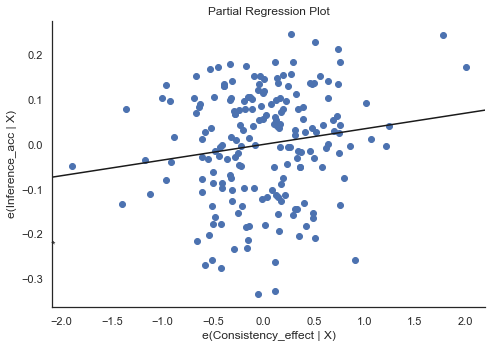

In [14]:
# Plot the partial correlation plot with age held constant
import statsmodels.api as sm
fig = sm.graphics.plot_partregress("Inference_acc", "Consistency_effect",["Age"],data=data,obs_labels=False)
fig.set_size_inches(7,5)
sns.set_theme(style="white")
fig.tight_layout()
# Get the Axes object
ax = fig.get_axes()[0]
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add an asterisk at the top of the plot
ax.text(0, 0.2, '*', ha='center', va='bottom', transform=ax.transAxes)

# Save the figure before calling fig.show()
#fig.savefig('/mnt/workdir/DCM/Result/paper/figure4/game2-hexagon_consistency_partial_correlation_plot.pdf', dpi=300, bbox_inches='tight',pad_inches=0,transparent=True)
fig.show()

X = data[['Consistency_effect','Age']]
Y = data['Inference_acc']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)
model_summary = model.summary()
print(model_summary)

# A GLM include age, brain actvitiy and inference

In [ ]:
# using the brian acitvitiy of multiple ROIs and age to predict inference accuracy

# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data =  participants_data.query("(game2_fmri>=0.5)")
subjects_id = data['Participant_ID'].to_list()

# load ROI
# # load HC
rHC = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/rHC_MNI152NL.nii.gz')
lHC = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/lHC_MNI152NL.nii.gz')
hc = image.math_img('np.logical_or(img1,img2)', img1=rHC, img2=lHC)
# load EC
# ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
# ec = image.binarize_img(ec,10)
# # # load OFC
rlOFC = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.lateralorbitofrontal.nii.gz')
llOFC = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.lateralorbitofrontal.nii.gz')
lofc = image.math_img('np.logical_or(img1,img2)', img1=rlOFC, img2=llOFC)
# # #
# rpOFC = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.parsorbitalis.nii.gz')
# lpOFC = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.parsorbitalis.nii.gz')
# ofc = image.math_img('np.logical_or(img1,img2)', img1=rpOFC, img2=lpOFC)
# # # # load vmPFC
vmPFC  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_merge_MNI152NL.nii.gz')
# # # # load PCC
rpcc = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.posteriorcingulate.nii.gz')
lpcc = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.posteriorcingulate.nii.gz')
pcc = image.math_img('np.logical_or(img1,img2)', img1=rpcc, img2=lpcc)
# # put ROIs into a dict
rois = {'lOFC':lofc,'vmPFC':vmPFC,'PCC':pcc,'HC':hc}
#rois = {'EC':ec}
# # load isthmuscingulate
# liscc = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.isthmuscingulate.nii.gz')
# riscc = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.isthmuscingulate.nii.gz')
# iscc = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
# rois = {'liscc':liscc,'riscc':riscc,'iscc':iscc}
# set camp
cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/distance_spct/Setall/6fold/{}/zmap/M2_corrxdistance_zmap.nii.gz'

# cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/grid_rsa_corr_trials/Setall/6fold/{}/rsa/rsa_ztransf_img_coarse_6fold.nii.gz'

# get each subject's activity in each ROI
for troi_name,troi in rois.items():
    print(troi_name,'is processing')
    # get activity in ROI
    subs_cmap_list = [cmap_template.format(sub_id) for sub_id in subjects_id]
    subs_mean_activity = np.mean(masking.apply_mask(subs_cmap_list, troi),axis=1)
    data[troi_name] = subs_mean_activity
print(len(subs_mean_activity))

In [ ]:
import statsmodels.api as sm
# using GLM to predict inference accuracy from brain activity and age
data['beh_diff'] = data['game2_test_acc'] - data['game1_acc']
X = data[['mPFC']]
Y = data['game1_acc']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)
model_summary = model.summary()
print(model_summary)

# 将摘要保存到文件
summary_file = '/mnt/workdir/DCM/Result/paper/figure3/Value/Value_mPFC-meidaiton-glm1_summary.txt'
with open(summary_file, 'w') as f:
    f.write(model_summary.as_text())
    f.close()

In [ ]:
# Replace 'IV', 'M', and 'DV' with the actual variable names in your dataset
iv = 'Age'
m = 'OFC'
dv = 'game1_acc'

# Path a: IV -> M
path_a = smf.ols(f"{m} ~ {iv}", data=data).fit()

# Path b: M -> DV, controlling for IV
path_b = smf.ols(f"{dv} ~ {m} + {iv}", data=data).fit()
lower, upper,indirect_effects = bootstrap_indirect_effect(data, iv, m, dv)
print(f"Bootstrapped {int(0.95 * 100)}% confidence interval for the indirect effect: ({lower:.8f}, {upper:.8f})")

In [ ]:
# Calculate lower and upper bounds
ci=0.95
lower = np.percentile(indirect_effects, (1 - ci) / 2 * 100)
upper = np.percentile(indirect_effects, (1 + ci) / 2 * 100)
print('mean:',np.mean(indirect_effects))
print('standard error:',np.std(indirect_effects))
# Plot histogram
fig, ax = plt.subplots()
n, bins, patches = ax.hist(indirect_effects, color='gray',bins=50)

# Find the bin with the highest frequency and its corresponding height
max_height = max(n)
max_height_index = np.where(n == max_height)[0][0]
max_height_bin = bins[max_height_index]

# Add vertical line at zero with height equal to the maximum frequency
ax.axvline(x=0, ymin=0, ymax=max_height, color='black', linestyle='--')

# Color the histogram between the lower and upper bounds blue
for i in range(len(patches)):
    if lower <= bins[i] < upper:
        patches[i].set_fc('lightsteelblue')

# Remove top and right spines
fig.suptitle(f"Bootstrapped {int(ci * 100)}% confidence interval: ({lower:.6f}, {upper:.6f})",size=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
savepath = r'/mnt/workdir/DCM/Result/paper/figure3/Distance/Distance_OFC-meidaiton-age2inference.pdf'
plt.savefig(savepath,bbox_inches='tight',pad_inches=0,dpi=300,transparent=True)
indirect_effects_cofe = pd.DataFrame({'mean_mediation':np.mean(indirect_effects),
                                      'std_mediation':np.std(indirect_effects)},index=['OFC'])
indirect_effects_cofe.to_csv(r'/mnt/workdir/DCM/Result/paper/figure3/Distance/OFC_indirect_effects_cofe.csv')

In [49]:
# check whether the manhattan distance can predict/meidate value effect and inference accuracy

# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('game1_fmri>=0.5')  # look out
subjects = data['Participant_ID'].to_list()

# set cmp template
rsa_zmap = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/grid_rsa_corr_trials/Setall/6fold/' \
           r'{}/rsa/rsa_ztransf_img_coarse_6fold.nii.gz'
distance_zmap = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/distance_spct/Setall/6fold/' \
                r'{}/zmap/M2_corrxdistance_zmap.nii.gz'

sub_rsa_zmap = [rsa_zmap.format(sub) for sub in subjects]
sub_distance_zmap = [distance_zmap.format(sub) for sub in subjects]

ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
ec = image.binarize_img(ec,10)
vmpfc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_merge_MNI152NL.nii.gz')
# extract mean activity of ROI for each subjects
data['hexagon'] = np.mean(masking.apply_mask(sub_rsa_zmap, ec), axis=1)
data['distance'] = np.mean(masking.apply_mask(sub_distance_zmap, vmpfc), axis=1)

/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
<ipython-input-49-faa7902175cf>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hexagon'] = np.mean(masking.apply_mask(sub_rsa_zmap, ec), axis=1)
<ipython-input-49-faa7902175cf>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [50]:
import statsmodels.api as sm
# using GLM to predict inference accuracy from brain activity and age
X = data[['Age','hexagon','distance']]
Y = data['game1_acc']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)
model_summary = model.summary()
print(model_summary)
#
# summary_file = '/mnt/workdir/DCM/Result/paper/figure3/hexagon_distance_mediation/age_glm1_summary.txt'
# with open(summary_file, 'w') as f:
#     f.write(model_summary.as_text())
#     f.close()

                            OLS Regression Results                            
Dep. Variable:              game1_acc   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     38.40
Date:                Wed, 31 May 2023   Prob (F-statistic):           1.26e-19
Time:                        10:08:23   Log-Likelihood:                 183.59
No. Observations:                 203   AIC:                            -359.2
Df Residuals:                     199   BIC:                            -345.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5505      0.022     25.240      0.0

In [48]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg

# Assuming you have a pandas DataFrame df with columns 'IV', 'DV', and 'Mediator'
# Replace 'IV', 'M', and 'DV' with the actual variable names in your dataset
iv = 'Age'
m = ['hexagon','distance']
dv = 'game1_acc'
# First we model the mediator using the IV
# model_mediator = ols(f"{m} ~ {iv}", data=data).fit()
# data['predicted_Mediator'] = model_mediator.predict(data[iv])
# model_dv_with_mediator = ols(f"{dv} ~ {iv} + {m}", data=data).fit()
# print(model_dv_with_mediator.summary())
# Mediation analysis
mediation_results = pg.mediation_analysis(data=data, x=iv, m=m, y=dv, seed=0,n_boot=5000,return_dist=False).round(5)
print(mediation_results)

                path     coef       se     pval  CI[2.5%]  CI[97.5%]  sig
0        hexagon ~ X  0.00044  0.00021  0.03500   0.00003    0.00086  Yes
1       distance ~ X  0.02690  0.00877  0.00245   0.00961    0.04419  Yes
2        Y ~ hexagon  2.14204  0.51395  0.00005   1.12859    3.15549  Yes
3       Y ~ distance  0.03662  0.01210  0.00280   0.01276    0.06049  Yes
4              Total  0.01288  0.00136  0.00000   0.01020    0.01556  Yes
5             Direct  0.01164  0.00135  0.00000   0.00898    0.01430  Yes
6   Indirect hexagon  0.00073  0.00043  0.04800   0.00008    0.00182  Yes
7  Indirect distance  0.00050  0.00035  0.05800   0.00002    0.00142   No


In [ ]:
# Replace 'IV', 'M', and 'DV' with the actual variable names in your dataset
iv = 'hexagon'
m = 'distance'
dv = 'Age'

lower, upper,indirect_effects = bootstrap_indirect_effect(data, iv, m, dv)
print(f"Bootstrapped {int(0.95 * 100)}% confidence interval for the indirect effect: ({lower:.8f}, {upper:.8f})")

In [ ]:
# Calculate lower and upper bounds
print('mean',np.mean(indirect_effects))
print('standard error',np.std(indirect_effects))
ci=0.95
lower = np.percentile(indirect_effects, (1 - ci) / 2 * 100)
upper = np.percentile(indirect_effects, (1 + ci) / 2 * 100)

# Plot histogram
fig, ax = plt.subplots()
n, bins, patches = ax.hist(indirect_effects, color='gray',bins=50)

# Find the bin with the highest frequency and its corresponding height
max_height = max(n)
max_height_index = np.where(n == max_height)[0][0]
max_height_bin = bins[max_height_index]

# Add vertical line at zero with height equal to the maximum frequency
ax.axvline(x=0, ymin=0, ymax=max_height, color='black', linestyle='--')

# Color the histogram between the lower and upper bounds blue
for i in range(len(patches)):
    if lower <= bins[i] < upper:
        patches[i].set_fc('lightsteelblue')

# Remove top and right spines
fig.suptitle(f"Bootstrapped {int(ci * 100)}% confidence interval: ({lower:.4f}, {upper:.4f})",size=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)